In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from sklearn import preprocessing

import os
import gc
import sys

In [2]:
def getdef(key, acc):
    return key['Definition of the characteristic-based anomaly variable'][acc]

In [3]:
def ispos(value):
    if value > 0:
        return 1
    return 0

In [4]:
key = pd.read_csv('var_key.csv')
key.set_index('Acronym', inplace=True)

In [5]:
d = pd.read_csv('peqw.csv')

In [6]:
d.rename(index=str, columns = {'Unnamed: 0':'time'}, inplace=True)

In [7]:
d.head()

,time,year,absacc,acc,age,agr,bm,bm_ia,cash,cashdebt,...,ps,nincr,divi,divo,rd,sin,IPO,convind,securedind,month
0,0,1980,0.020437,-0.019961,0.004841,-0.051247,0.002593,0.026180,0.005222,-0.066361,...,-0.021583,0.003167,-0.031233,-0.031233,-0.031233,0.096761,0.096761,0.004620,0.096761,1
1,1,1980,0.015636,-0.000363,-0.018122,-0.014145,-0.021253,-0.004250,0.003154,-0.027831,...,-0.023228,-0.017170,-0.051512,-0.051512,-0.051512,-0.014712,-0.014712,-0.003763,-0.014712,2
2,2,1980,-0.040065,-0.018086,-0.014526,0.001264,0.033694,0.022895,-0.003068,0.042815,...,0.025033,0.008833,0.011847,0.011847,0.011847,-0.160399,-0.160399,-0.008245,-0.160399,3
3,3,1980,-0.017147,-0.013814,0.001677,0.001489,-0.022916,-0.014910,-0.015351,0.007168,...,0.027996,0.029631,0.035142,0.035142,0.035142,0.053434,0.053434,0.000111,0.053434,4
4,4,1980,-0.005577,0.005240,-0.004074,0.029255,-0.010575,-0.011134,0.015279,0.022806,...,0.004142,-0.003777,0.019834,0.019834,0.019834,0.073763,0.073763,0.006476,0.073763,5


In [8]:
d['mom1m'].head()

0   -0.019036
1   -0.011720
2   -0.059039
3   -0.039296
4   -0.039749
Name: mom1m, dtype: float64

In [9]:
mom1mcorr = d.corr()['mom1m']

In [10]:
key.head()

,Paper’s author(s),"Date, Journal",Definition of the characteristic-based anomaly variable
Acronym,,,
absacc,"Bandyopadhyay, Huang & Wirjanto","2010, WP",Absolute value of acc.
acc,Sloan,"1996, TAR",Annual income before extraordinary items (ib) ...
aeavol,"Lerman, Livnat & Mendenhall","2007, WP",Average daily trading volume (vol) for 3 days ...
age,"Jiang, Lee & Zhang","2005, RAS",Number of years since first Compustat coverage.
agr,"Cooper, Gulen & Schill","2008, JF",Annual percent change in total assets (at).


In [11]:
mom1mcorr.sort_values()

baspread        -0.471281
retvol          -0.455118
ill             -0.420183
idiovol         -0.419811
IPO             -0.413152
sin             -0.413152
beta            -0.411018
betasq          -0.408732
maxret          -0.374244
stdcf           -0.370217
stdacc          -0.364887
disp            -0.364153
absacc          -0.358972
std_turn        -0.352503
roavol          -0.343229
convind         -0.332445
orgcap          -0.321499
chcsho          -0.319855
depr            -0.311359
pctacc          -0.308728
fgr5yr          -0.306707
secured         -0.291472
herf            -0.268339
turn            -0.266770
chpmia          -0.261321
securedind      -0.254101
cash            -0.235796
salerec         -0.209785
pchdepr         -0.209455
currat          -0.198132
                   ...   
chtx             0.212632
salecash         0.218421
rsup             0.223484
dolvol           0.255252
zerotrade        0.275886
rd               0.277884
bm               0.281041
pchgm_pchsal

In [12]:
getdef(key, 'mom6m')

'5-month cumulative returns ending one month before month end.'

In [13]:
getdef(key, 'chmom')

'Cumulative returns from months t-6 to t-1 minus months t-12 to t-7.'

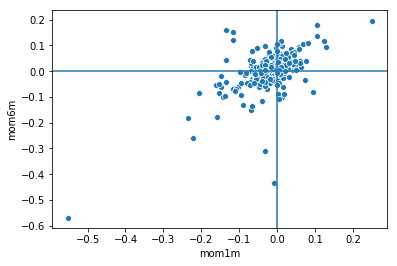

In [14]:
sns.scatterplot(x=d['mom1m'], y=d['mom6m'])
plt.axvline(0,0,1)
plt.axhline(0,0,1)

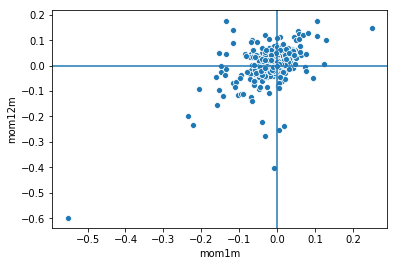

In [15]:
sns.scatterplot(x=d['mom1m'], y=d['mom12m'])
plt.axvline(0,0,1)
plt.axhline(0,0,1)

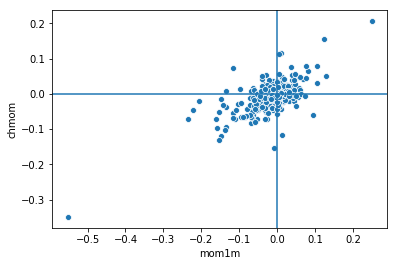

In [16]:
sns.scatterplot(x=d['mom1m'], y=d['chmom'])
plt.axvline(0,0,1)
plt.axhline(0,0,1)

In [17]:
# Chmom prediction
chmom_pred = []
for i in range(len(d['chmom'])):
    chmom_pred.append(d['chmom'].iloc[i] * d['mom1m'].iloc[i])

print('right', sum([1 for i in chmom_pred if i > 0]))
print('wrong', sum([1 for i in chmom_pred if i < 0]))

right 295
wrong 125


In [18]:
# mom6m prediction
mom6m_pred = []
for i in range(len(d['mom6m'])):
    mom6m_pred.append(d['mom6m'].iloc[i] * d['mom1m'].iloc[i])

print('right', sum([1 for i in mom6m_pred if i > 0]))
print('wrong', sum([1 for i in mom6m_pred if i < 0]))

right 238
wrong 182


In [19]:
# mom12m prediction
mom12m_pred = []
for i in range(len(d['mom12m'])):
    mom12m_pred.append(d['mom12m'].iloc[i] * d['mom1m'].iloc[i])

print('right', sum([1 for i in mom12m_pred if i > 0]))
print('wrong', sum([1 for i in mom12m_pred if i < 0]))

right 228
wrong 192


In [20]:
m = d[['time', 'year', 'month', 'mom1m', 'mom6m', 'mom12m', 'chmom']]

In [79]:
m126 = []
for i in range(len(m['time'])):
    m126.append(m['mom6m'].iloc[i] - m['chmom'].iloc[i])
m['mom126m'] = m126

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [82]:
m.head()

,time,year,month,mom1m,mom6m,mom12m,chmom,mom126m
0,0,1980,1,-0.019036,0.023017,0.043283,-0.019630,0.042647
1,1,1980,2,-0.011720,0.039917,0.047276,-0.009961,0.049878
2,2,1980,3,-0.059039,-0.044538,-0.060338,-0.010357,-0.034181
3,3,1980,4,-0.039296,0.043713,0.048351,-0.027406,0.071118
4,4,1980,5,-0.039749,-0.030409,-0.017396,-0.034548,0.004139


In [83]:
# mom126m prediction
mom126m_pred = []
for i in range(len(m['mom126m'])):
    mom126m_pred.append(m['mom126m'].iloc[i] * m['mom1m'].iloc[i])

print('right', sum([1 for i in mom126m_pred if i > 0]))
print('wrong', sum([1 for i in mom126m_pred if i < 0]))

right 187
wrong 233


In [78]:
m['mom126m'].head()

0    0.042647
1    0.049878
2   -0.034181
3    0.071118
4    0.004139
Name: mom126m, dtype: float64

In [23]:
# bm1 = []
# for i in range(len(m['time'])):
#     bm1.append(ispos(m['mom1m'].iloc[i]))
# m['bmom1m'] = bm1

In [24]:
# bm6 = []
# for i in range(len(m['time'])):
#     bm6.append(ispos(m['mom6m'].iloc[i]))
# m['bmom6m'] = bm6

In [25]:
# bm12 = []
# for i in range(len(m['time'])):
#     bm12.append(ispos(m['mom12m'].iloc[i]))
# m['bmom12m'] = bm12

In [26]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420 entries, 0 to 419
Columns: 105 entries, time to month
dtypes: float64(102), int64(3)
memory usage: 367.8+ KB


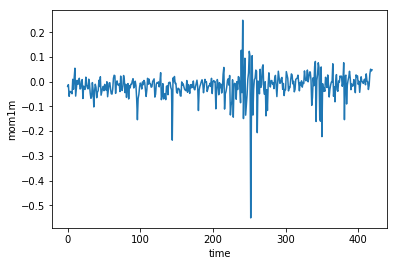

In [27]:
sns.lineplot(y=d['mom1m'], x=d['time'])

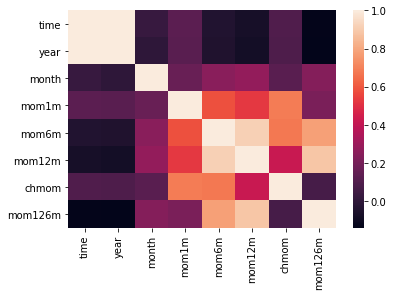

In [28]:
sns.heatmap(data=m.corr())

In [29]:
m.corr()['mom1m']

time       0.128251
year       0.123611
month      0.164729
mom1m      1.000000
mom6m      0.585264
mom12m     0.526691
chmom      0.684140
mom126m    0.213199
Name: mom1m, dtype: float64

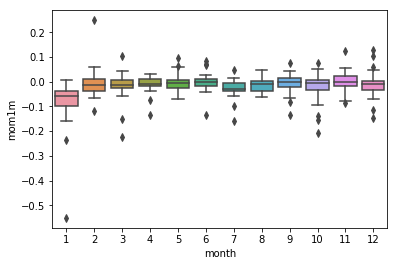

In [30]:
sns.boxplot(x=m['month'],y=m['mom1m'])

In [32]:
sm = m.copy()

In [58]:
bmom1m = [0 if i > 0 else 1 for i in list(sm['mom1m'])]
# for i in range(len(sm)):
#     bmom1m.append(sm['mom1m'].iloc[i])
sm['bmom1m'] = bmom1m

In [60]:
sm.drop('mom1m', axis=1, inplace=True)

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(sm.drop('bmom1m', axis=1))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
scaled_features = scaler.transform(sm.drop('bmom1m', axis=1))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [64]:
sm_feat = pd.DataFrame(scaled_features, columns=sm.columns[:-1])
sm_feat.head()

,time,year,month,mom6m,mom12m,chmom,mom126m
0,-1.727932,-1.683251,-1.593255,0.303891,0.559821,-0.349430,0.708035
1,-1.719684,-1.683251,-1.303572,0.583300,0.621593,-0.093865,0.870044
2,-1.711436,-1.683251,-1.013890,-0.813001,-1.043218,-0.104342,-1.013313
3,-1.703188,-1.683251,-0.724207,0.646057,0.638225,-0.554947,1.345946
4,-1.694940,-1.683251,-0.434524,-0.579403,-0.378906,-0.743725,-0.154747


In [65]:
from sklearn.model_selection import train_test_split
KX_train, KX_test, ky_train, ky_test = train_test_split(scaled_features, 
                                                        sm['bmom1m'],
                                                       test_size=.30)

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(KX_train, ky_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [67]:
pred = knn.predict(X_test)

In [68]:
from sklearn.metrics import classification_report,confusion_matrix

In [70]:
print(confusion_matrix(ky_test, pred))

[[44  0]
 [81  1]]


In [87]:
print(classification_report(ky_test, pred))
KX_test.shape

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        44
           1       0.76      0.87      0.81        82

   micro avg       0.74      0.74      0.74       126
   macro avg       0.72      0.68      0.69       126
weighted avg       0.73      0.74      0.73       126



(126, 7)

In [84]:
error_rate = []

# Will take some time
for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(KX_train,ky_train)
    pred_i = knn.predict(KX_test)
    error_rate.append(np.mean(pred_i != ky_test))

[0.2857142857142857, 0.31746031746031744, 0.2619047619047619, 0.2698412698412698, 0.30158730158730157, 0.2857142857142857, 0.2777777777777778, 0.2857142857142857, 0.2857142857142857, 0.2698412698412698, 0.29365079365079366, 0.2857142857142857, 0.2777777777777778, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.3333333333333333, 0.3253968253968254, 0.30952380952380953, 0.30952380952380953, 0.29365079365079366, 0.29365079365079366, 0.30158730158730157, 0.29365079365079366, 0.2857142857142857, 0.2857142857142857, 0.29365079365079366, 0.30158730158730157, 0.29365079365079366, 0.30158730158730157, 0.30158730158730157, 0.2857142857142857, 0.30158730158730157, 0.30952380952380953, 0.30158730158730157, 0.30952380952380953, 0.30158730158730157, 0.30952380952380953, 0.30952380952380953, 0.31746031746031744, 0.3253968253968254, 0.31746031746031744, 0.3253968253968254, 0.30158730158730157, 0.3253968253968254, 0.30158730158730157, 0.30158730158730157, 0.30158730158730157, 0.3174603174

Text(0, 0.5, 'Error Rate')

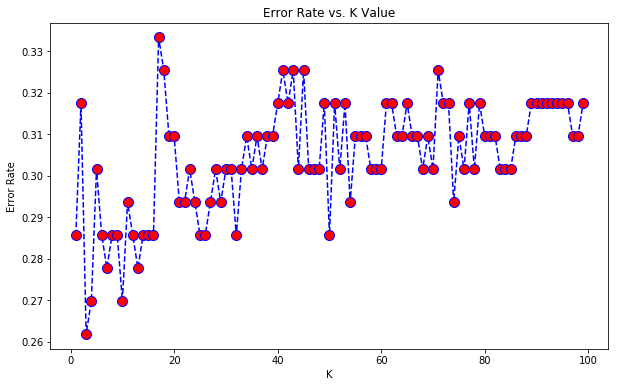

In [86]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', 
         linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [74]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(KX_train, ky_train)
pred = knn.predict(KX_test)

print(confusion_matrix(ky_test,pred))
print(classification_report(ky_test,pred))

[[22 22]
 [11 71]]
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        44
           1       0.76      0.87      0.81        82

   micro avg       0.74      0.74      0.74       126
   macro avg       0.72      0.68      0.69       126
weighted avg       0.73      0.74      0.73       126



In [33]:
X = m.drop(['mom1m'], axis=1)
y = m['mom1m']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.30, 
                                                    random_state=101)

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
lm.intercept_

792064930375.6459

In [38]:
coeff_df = pd.DataFrame(lm.coef_, X.columns)
coeff_df

,0
time,3.333466e+07
year,-4.000160e+08
month,-3.333466e+07
mom6m,1.919268e+04
mom12m,1.213004e+00
chmom,-1.919254e+04
mom126m,-1.919402e+04


In [39]:
predictions = lm.predict(X_test)

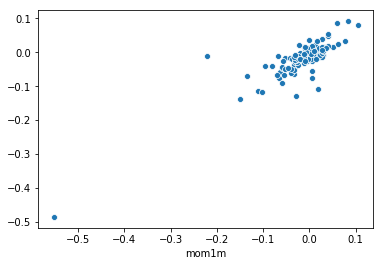

In [40]:
sns.scatterplot(y_test,predictions)

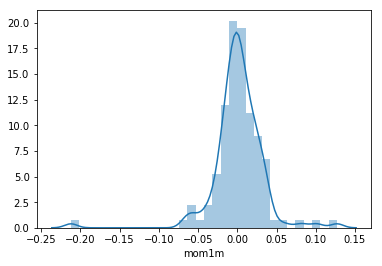

In [41]:
sns.distplot((y_test-predictions));

In [42]:
from sklearn import metrics

In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.020159518076388893
MSE: 0.0010841011809668592
RMSE: 0.03292569180695919


In [44]:
pm = m.copy()

In [45]:
pmom1m = []
pmom6m = []
pmom12m = []
pchmom = []
pmom126m = []

count = 0

for i in range(len(pm)):
    count += 1
    pmom1m.append(pm['mom1m'].iloc[i] * 100)
    pmom6m.append(pm['mom6m'].iloc[i] * 100)
    pmom12m.append(pm['mom12m'].iloc[i] * 100)
    pchmom.append(pm['chmom'].iloc[i] * 100)
    pmom126m.append(pm['mom126m'].iloc[i] * 100)

pm['pmom1m'] = pmom1m
pm['pmom6m'] = pmom6m
pm['pmom12m'] = pmom12m
pm['pchmom'] = pchmom
pm['pmom126m'] = pmom126m

In [46]:
pm.head()

,time,year,month,mom1m,mom6m,mom12m,chmom,mom126m,pmom1m,pmom6m,pmom12m,pchmom,pmom126m
0,0,1980,1,-0.019036,0.023017,0.043283,-0.019630,0.042647,-1.903564,2.301678,4.328334,-1.963001,4.264679
1,1,1980,2,-0.011720,0.039917,0.047276,-0.009961,0.049878,-1.172046,3.991671,4.727634,-0.996092,4.987763
2,2,1980,3,-0.059039,-0.044538,-0.060338,-0.010357,-0.034181,-5.903874,-4.453789,-6.033782,-1.035732,-3.418057
3,3,1980,4,-0.039296,0.043713,0.048351,-0.027406,0.071118,-3.929560,4.371252,4.835142,-2.740559,7.111811
4,4,1980,5,-0.039749,-0.030409,-0.017396,-0.034548,0.004139,-3.974892,-3.040883,-1.739642,-3.454786,0.413903


In [47]:
pm.drop(['mom1m', 'mom6m', 'mom12m', 'chmom', 'mom126m'], axis=1, inplace=True)

In [48]:
# features = d.columns
# x = d[features]
# y = d['mom1m']
# x = StandardScaler().fit_transform(x)

In [49]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents, 
#                            columns = ['principal component 1', 
#                                       'principal component 2'])

In [50]:
# finalDf = pd.concat([principalDf, d[['mom1m']]], axis = 1)

In [51]:
# sns.scatterplot(x=principalDf['principal component 1'], 
#                 y=principalDf['principal component 2'])

In [ ]:
sm.to_csv()